<a href="https://colab.research.google.com/github/gowrisankar393/vaylen-transitlk/blob/Multi-Sensor-Fusion-Crash-Detection/TransitLK_MSFCD_DBA_XGBipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi Sensor Fusion Crash Detection - Driver Behaviour Analysis**

## **Setup & Data Loading**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("BUS DRIVER BEHAVIOR DETECTION - XGBOOST MODEL")


# Mount Google Drive (if using Drive)
# from google.colab import drive
# drive.mount('/content/drive')

# For direct upload in Colab
from google.colab import files
print("\nPlease upload your 'sensor_raw.csv' file:")
uploaded = files.upload()

BUS DRIVER BEHAVIOR DETECTION - XGBOOST MODEL

Please upload your 'sensor_raw.csv' file:


Saving sensor_raw.csv to sensor_raw.csv


## **Load & Inspect Data**

In [2]:
# Load the dataset
df = pd.read_csv('sensor_raw.csv')
print(f"\nDataset loaded: {df.shape[0]} rows, {df.shape[1]} columns\n")

# Display first few rows
print("First 5 rows:")
print(df.head())

print("\nColumn names:")
print(df.columns.tolist())

# Check column info
print("\nDataset Info:")
df.info()

print("\nMissing Values:")
print(df.isnull().sum())

print("\nDuplicated rows:", df.duplicated().sum())


Dataset loaded: 1114 rows, 7 columns

First 5 rows:
   Target(Class)     GyroX     GyroY     GyroZ      AccX      AccY      AccZ
0              1 -0.923664  3.694656  0.824427  0.162598 -0.086670 -0.969482
1              1 -0.908397  4.534351  0.832061  0.175781 -0.100586 -1.013184
2              1  0.786260  3.969466  0.587786  0.322754 -0.140381 -0.911621
3              1  0.335878  4.564885 -0.251908  0.480225 -0.226807 -0.936768
4              1  3.351145  2.694656 -0.106870  0.426025 -0.253906 -0.950195

Column names:
['Target(Class)', 'GyroX', 'GyroY', 'GyroZ', 'AccX', 'AccY', 'AccZ']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1114 entries, 0 to 1113
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Target(Class)  1114 non-null   int64  
 1   GyroX          1114 non-null   float64
 2   GyroY          1114 non-null   float64
 3   GyroZ          1114 non-null   float64
 4   AccX       

## **Exploratory Data Analysis (EDA)**

📊 EXPLORATORY DATA ANALYSIS

1. Class Distribution:
Target(Class)
1    252
2    288
3    350
4    224
Name: count, dtype: int64

Class Distribution (Percentages):
  Class 1 (Sudden Acceleration): 252 samples (22.6%)
  Class 2 (Sudden Right Turn): 288 samples (25.9%)
  Class 3 (Sudden Left Turn): 350 samples (31.4%)
  Class 4 (Sudden Brake): 224 samples (20.1%)


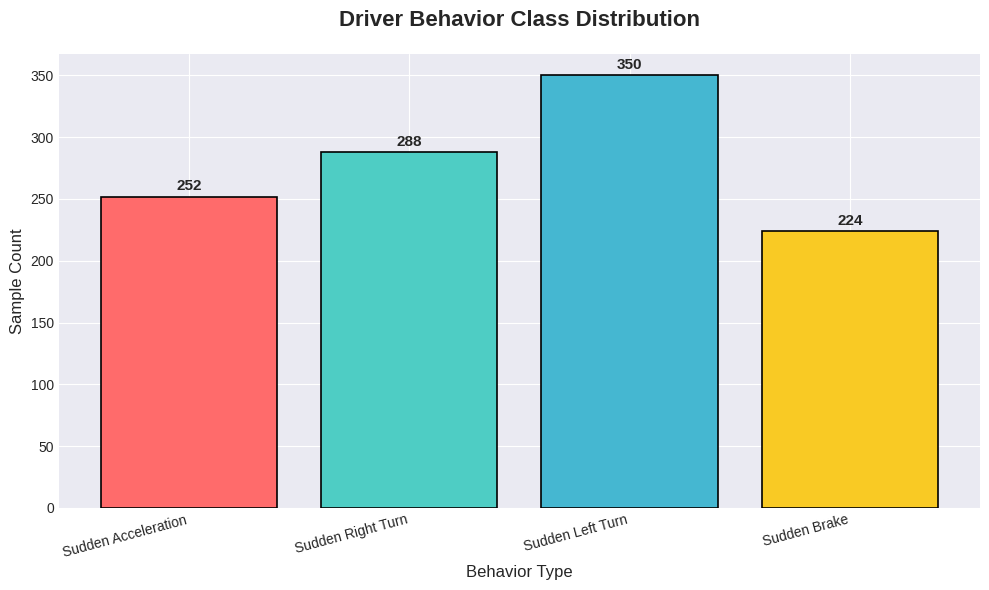


2. Sensor Statistics:
             GyroX        GyroY        GyroZ         AccX         AccY  \
count  1114.000000  1114.000000  1114.000000  1114.000000  1114.000000   
mean     -0.829957     4.122309     1.076404     0.252417    -0.095110   
std       3.404297     3.252790    12.049384     0.183155     0.190407   
min     -14.946565   -10.351145   -50.259542    -0.252686    -0.793457   
25%      -2.274809     2.610687     0.282443     0.132202    -0.179077   
50%      -0.698473     4.290076     0.961832     0.244507    -0.102295   
75%       0.784351     5.761450     1.992366     0.372559    -0.023010   
max      12.778626    16.793893    45.442748     0.747803     0.768555   

              AccZ  
count  1114.000000  
mean     -0.983215  
std       0.098061  
min      -1.367920  
25%      -1.031372  
50%      -0.986938  
75%      -0.928223  
max      -0.456787  


In [3]:
print("📊 EXPLORATORY DATA ANALYSIS")


# Class distribution analysis
print("\n1. Class Distribution:")
class_counts = df['Target(Class)'].value_counts().sort_index()
print(class_counts)

# Map class numbers to behavior names
behavior_map = {
    1: 'Sudden Acceleration',
    2: 'Sudden Right Turn',
    3: 'Sudden Left Turn',
    4: 'Sudden Brake'
}

print("\nClass Distribution (Percentages):")
for cls, count in class_counts.items():
    pct = (count / len(df)) * 100
    print(f"  Class {cls} ({behavior_map[cls]}): {count} samples ({pct:.1f}%)")

# Visualize class distribution
plt.figure(figsize=(10, 6))
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#f9ca24']
bars = plt.bar([behavior_map[i] for i in class_counts.index],
               class_counts.values, color=colors, edgecolor='black', linewidth=1.2)
plt.title('Driver Behavior Class Distribution', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Behavior Type', fontsize=12)
plt.ylabel('Sample Count', fontsize=12)
plt.xticks(rotation=15, ha='right')

# Add value labels on bars
for bar, val in zip(bars, class_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             str(val), ha='center', fontweight='bold', fontsize=11)
plt.tight_layout()
plt.show()

# Sensor statistics
print("\n2. Sensor Statistics:")
sensor_cols = ['GyroX', 'GyroY', 'GyroZ', 'AccX', 'AccY', 'AccZ']
print(df[sensor_cols].describe())

## **Data Visualization**

DATA VISUALIZATION


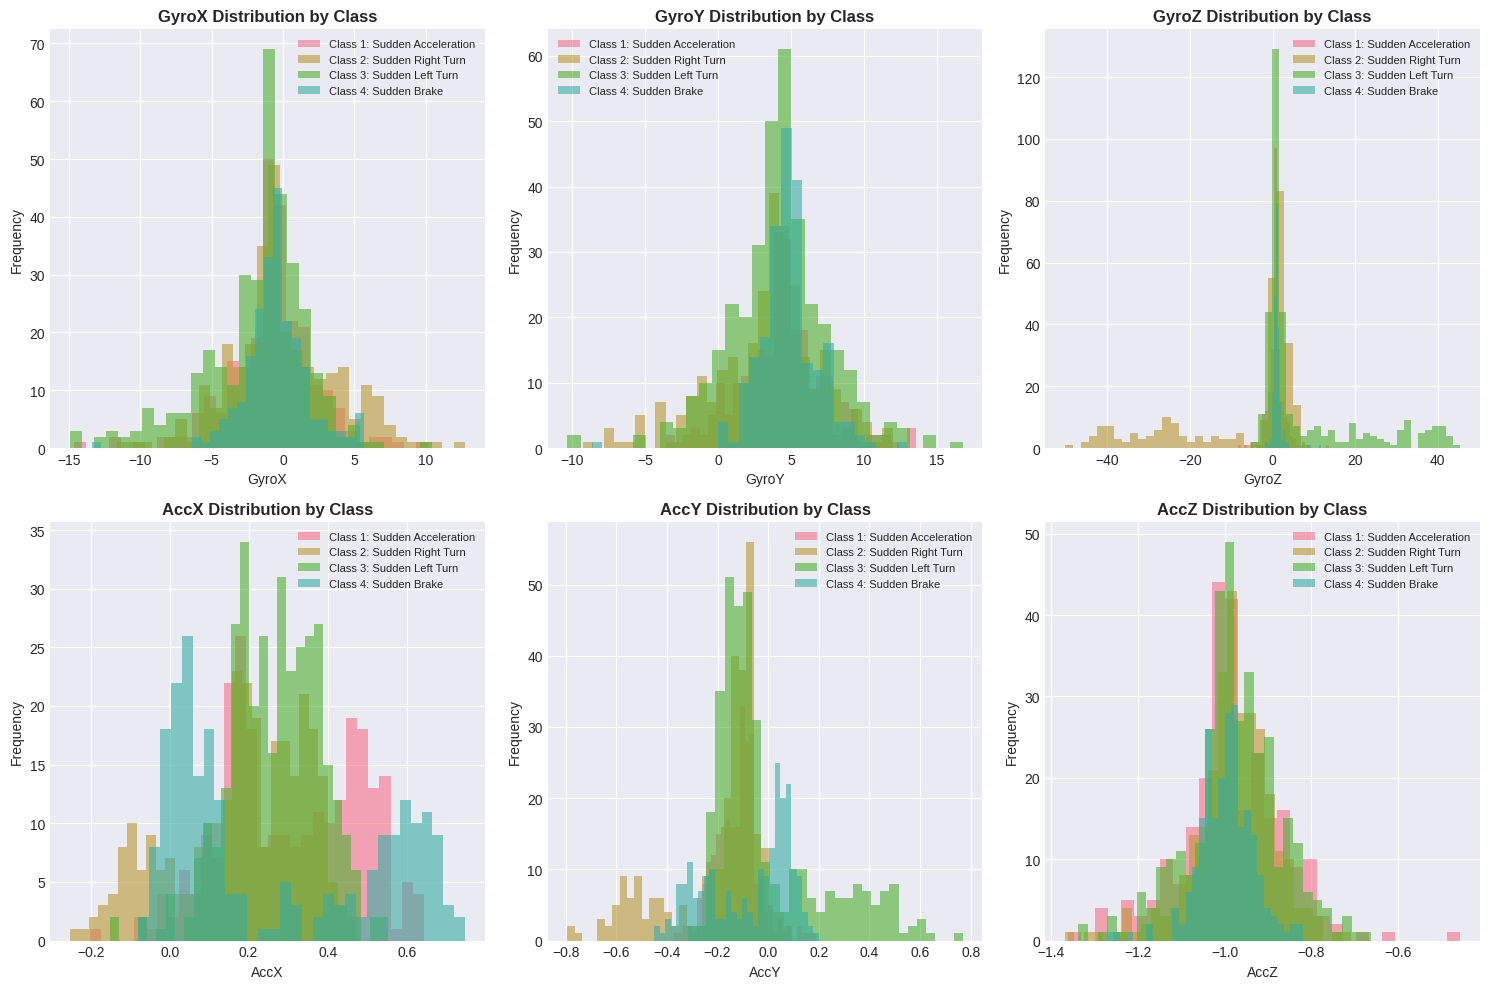

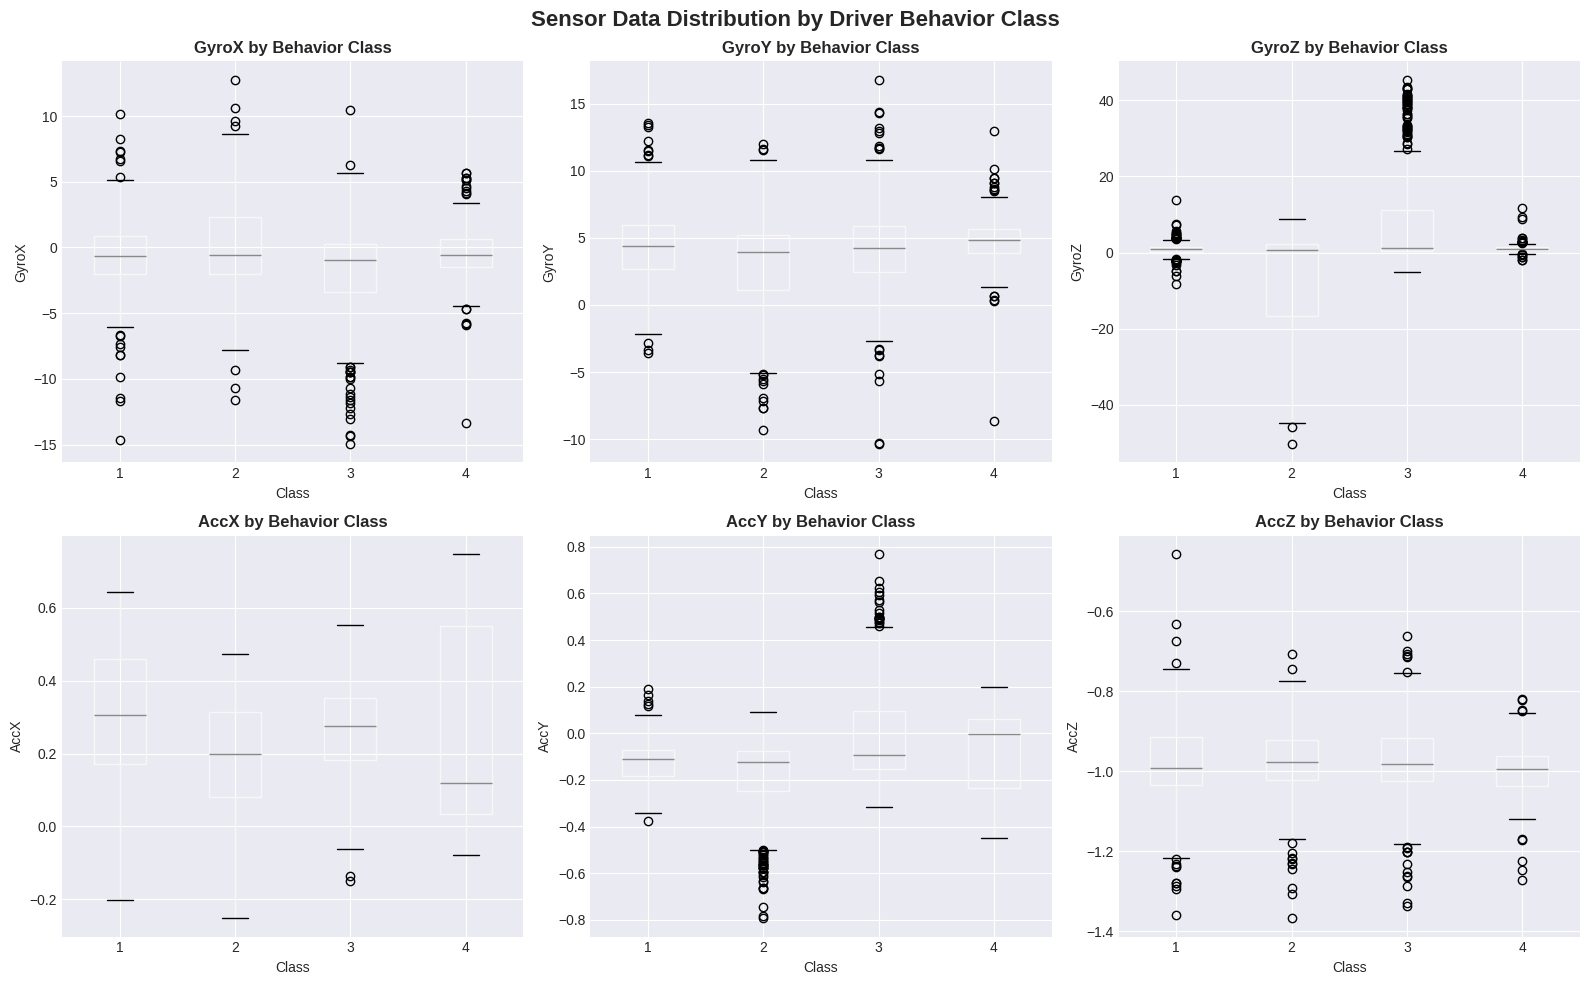

In [4]:
print("DATA VISUALIZATION")


# Plot sensor distributions by class
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(sensor_cols):
    ax = axes[idx]
    for cls in sorted(df['Target(Class)'].unique()):
        subset = df[df['Target(Class)'] == cls][col]
        ax.hist(subset, bins=30, alpha=0.6, label=f'Class {cls}: {behavior_map[cls]}')
    ax.set_title(f'{col} Distribution by Class', fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# Box plots for sensor data by class
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(sensor_cols):
    ax = axes[idx]
    df.boxplot(column=col, by='Target(Class)', ax=ax)
    ax.set_title(f'{col} by Behavior Class', fontweight='bold')
    ax.set_xlabel('Class')
    ax.set_ylabel(col)

plt.suptitle('Sensor Data Distribution by Driver Behavior Class', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## **Data Preprocessing & Feature Engineering**

In [5]:
print("DATA PREPROCESSING & FEATURE ENGINEERING")

# Create a copy for processing
df_processed = df.copy()

# Rename columns for clarity (optional but helpful)
df_processed = df_processed.rename(columns={
    'Target(Class)': 'target',
    'GyroX': 'gyro_x',
    'GyroY': 'gyro_y',
    'GyroZ': 'gyro_z',
    'AccX': 'accel_x',
    'AccY': 'accel_y',
    'AccZ': 'accel_z'
})

print(f"\n1. Dataset shape before processing: {df_processed.shape}")

# Handle missing values
print("\n2. Checking for missing values...")
missing_before = df_processed.isnull().sum().sum()
print(f"Missing values before: {missing_before}")

if missing_before > 0:
    df_processed = df_processed.fillna(df_processed.median())
    print(f"Missing values after: {df_processed.isnull().sum().sum()}")

# Separate features and target
feature_cols = ['gyro_x', 'gyro_y', 'gyro_z', 'accel_x', 'accel_y', 'accel_z']
X = df_processed[feature_cols]
y = df_processed['target'] - 1  # Convert to 0-indexed (0,1,2,3) for XGBoost

print(f"\n3. Feature matrix shape: {X.shape}")
print(f"   Target vector shape: {y.shape}")
print(f"   Unique classes: {sorted(y.unique())}")

# Feature Engineering (domain knowledge for driving behavior)
print("\n4. Engineering new features...")

X_engineered = X.copy()

# 1. Acceleration magnitude (total G-force) - indicates sudden speed changes
X_engineered['accel_magnitude'] = np.sqrt(
    X_engineered['accel_x']**2 + X_engineered['accel_y']**2 + X_engineered['accel_z']**2
)

# 2. Gyroscope magnitude (total rotation) - indicates turns
X_engineered['gyro_magnitude'] = np.sqrt(
    X_engineered['gyro_x']**2 + X_engineered['gyro_y']**2 + X_engineered['gyro_z']**2
)

# 3. Jerk (rate of change of acceleration) - using rolling window approximation
# Since sampling is ~2Hz, we use diff to approximate derivative
X_engineered['accel_x_jerk'] = X_engineered['accel_x'].diff().fillna(0)
X_engineered['accel_y_jerk'] = X_engineered['accel_y'].diff().fillna(0)
X_engineered['accel_z_jerk'] = X_engineered['accel_z'].diff().fillna(0)
X_engineered['jerk_magnitude'] = np.sqrt(
    X_engineered['accel_x_jerk']**2 +
    X_engineered['accel_y_jerk']**2 +
    X_engineered['accel_z_jerk']**2
)

# 4. Vertical acceleration (Z-axis dominant for braking/acceleration)
X_engineered['accel_z_abs'] = np.abs(X_engineered['accel_z'])

# 5. Lateral acceleration (X-Y plane for turns)
X_engineered['accel_lateral'] = np.sqrt(
    X_engineered['accel_x']**2 + X_engineered['accel_y']**2
)

# 6. Yaw rate importance (Z-axis rotation for turns)
X_engineered['gyro_z_abs'] = np.abs(X_engineered['gyro_z'])

print("   ✓ accel_magnitude - total acceleration force")
print("   ✓ gyro_magnitude - total rotation force")
print("   ✓ jerk_magnitude - sudden changes in acceleration")
print("   ✓ accel_z_abs - vertical movement (brake/accel)")
print("   ✓ accel_lateral - sideways forces (turns)")
print("   ✓ gyro_z_abs - yaw rotation (turning rate)")

# Final feature set
FINAL_FEATURES = [
    'gyro_x', 'gyro_y', 'gyro_z',
    'accel_x', 'accel_y', 'accel_z',
    'accel_magnitude', 'gyro_magnitude',
    'jerk_magnitude', 'accel_z_abs',
    'accel_lateral', 'gyro_z_abs'
]

X_final = X_engineered[FINAL_FEATURES]
print(f"\n5. Final feature matrix: {X_final.shape[1]} features")
print("   Features:", FINAL_FEATURES)

DATA PREPROCESSING & FEATURE ENGINEERING

1. Dataset shape before processing: (1114, 7)

2. Checking for missing values...
Missing values before: 0

3. Feature matrix shape: (1114, 6)
   Target vector shape: (1114,)
   Unique classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]

4. Engineering new features...
   ✓ accel_magnitude - total acceleration force
   ✓ gyro_magnitude - total rotation force
   ✓ jerk_magnitude - sudden changes in acceleration
   ✓ accel_z_abs - vertical movement (brake/accel)
   ✓ accel_lateral - sideways forces (turns)
   ✓ gyro_z_abs - yaw rotation (turning rate)

5. Final feature matrix: 12 features
   Features: ['gyro_x', 'gyro_y', 'gyro_z', 'accel_x', 'accel_y', 'accel_z', 'accel_magnitude', 'gyro_magnitude', 'jerk_magnitude', 'accel_z_abs', 'accel_lateral', 'gyro_z_abs']


## **Handle Class Imbalance**

In [6]:
print("HANDLING CLASS IMBALANCE")
print(f"\nBefore balancing:")
class_dist = pd.Series(y).value_counts().sort_index()
for idx, count in class_dist.items():
    print(f"   Class {idx}: {count} samples ({behavior_map[idx+1]})")

# Check if imbalance is significant (if max/min ratio > 2)
max_class = class_dist.max()
min_class = class_dist.min()
imbalance_ratio = max_class / min_class

if imbalance_ratio > 1.5:
    print(f"\nImbalance detected (ratio: {imbalance_ratio:.2f}). Applying SMOTE...")

    from imblearn.over_sampling import SMOTE

    smote = SMOTE(random_state=42, k_neighbors=min(3, min_class-1))
    X_balanced, y_balanced = smote.fit_resample(X_final, y)

    print(f"\nAfter SMOTE balancing:")
    balanced_dist = pd.Series(y_balanced).value_counts().sort_index()
    for idx, count in balanced_dist.items():
        print(f"   Class {idx}: {count} samples")
else:
    print(f"\n✓ Classes are relatively balanced (ratio: {imbalance_ratio:.2f}). No SMOTE needed.")
    X_balanced, y_balanced = X_final, y

print(f"\nFinal dataset shape: {X_balanced.shape}")

HANDLING CLASS IMBALANCE

Before balancing:
   Class 0: 252 samples (Sudden Acceleration)
   Class 1: 288 samples (Sudden Right Turn)
   Class 2: 350 samples (Sudden Left Turn)
   Class 3: 224 samples (Sudden Brake)

Imbalance detected (ratio: 1.56). Applying SMOTE...

After SMOTE balancing:
   Class 0: 350 samples
   Class 1: 350 samples
   Class 2: 350 samples
   Class 3: 350 samples

Final dataset shape: (1400, 12)


## **Train Test Split**

In [7]:
print("TRAIN-TEST SPLIT")


# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced,
    test_size=0.2,
    random_state=42,
    stratify=y_balanced
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Check class distribution in splits
print("\nClass distribution in training set:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for idx, count in train_dist.items():
    print(f"   Class {idx}: {count} ({count/len(y_train)*100:.1f}%)")

print("\nClass distribution in test set:")
test_dist = pd.Series(y_test).value_counts().sort_index()
for idx, count in test_dist.items():
    print(f"   Class {idx}: {count} ({count/len(y_test)*100:.1f}%)")

TRAIN-TEST SPLIT
Train set: 1120 samples
Test set: 280 samples

Class distribution in training set:
   Class 0: 280 (25.0%)
   Class 1: 280 (25.0%)
   Class 2: 280 (25.0%)
   Class 3: 280 (25.0%)

Class distribution in test set:
   Class 0: 70 (25.0%)
   Class 1: 70 (25.0%)
   Class 2: 70 (25.0%)
   Class 3: 70 (25.0%)


## **Model Training**

In [10]:
print("TRAINING XGBOOST MODEL")

print(f"\nXGBoost Version: {xgb.__version__}")

# Initialize XGBoost with parameters tuned for sensor data
model = xgb.XGBClassifier(
    n_estimators=300,          # More trees for complex multi-class problem
    max_depth=10,               # Deeper trees for capturing sensor patterns
    learning_rate=0.1,         # Standard learning rate
    subsample=0.8,             # Prevent overfitting
    colsample_bytree=0.8,      # Feature sampling
    min_child_weight=3,        # Prevent overfitting on small datasets
    gamma=0.1,                 # Minimum loss reduction for split
    reg_alpha=0.1,             # L1 regularization
    reg_lambda=1.0,            # L2 regularization
    random_state=42,
    eval_metric='mlogloss',    # Multi-class log loss
    objective='multi:softprob', # Multi-class with probabilities
    num_class=4                # 4 classes (0,1,2,3)
)

print("\nModel Parameters:")
print(f"   n_estimators: {model.n_estimators}")
print(f"   max_depth: {model.max_depth}")
print(f"   learning_rate: {model.learning_rate}")
print(f"   objective: {model.objective}")
print(f"   num_class: 4")

print("\nTraining in progress...")

# Train with evaluation set for early stopping monitoring
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=50  # Print every 50 iterations
)

print(f"\nTraining complete!")

TRAINING XGBOOST MODEL

XGBoost Version: 3.1.3

Model Parameters:
   n_estimators: 300
   max_depth: 10
   learning_rate: 0.1
   objective: multi:softprob
   num_class: 4

Training in progress...
[0]	validation_0-mlogloss:1.28354	validation_1-mlogloss:1.30248
[50]	validation_0-mlogloss:0.21638	validation_1-mlogloss:0.63353
[100]	validation_0-mlogloss:0.10121	validation_1-mlogloss:0.62217
[150]	validation_0-mlogloss:0.07192	validation_1-mlogloss:0.63085
[200]	validation_0-mlogloss:0.06304	validation_1-mlogloss:0.63801
[250]	validation_0-mlogloss:0.06004	validation_1-mlogloss:0.64206
[299]	validation_0-mlogloss:0.05773	validation_1-mlogloss:0.64421

Training complete!


## **Model Evaluation**

MODEL EVALUATION

Test Accuracy: 74.64%
F1-Score (Macro): 0.7438
F1-Score (Weighted): 0.7438

Classification Report:
              precision    recall  f1-score   support

Sudden Accel       0.64      0.63      0.63        70
  Right Turn       0.75      0.83      0.79        70
   Left Turn       0.69      0.61      0.65        70
Sudden Brake       0.89      0.91      0.90        70

    accuracy                           0.75       280
   macro avg       0.74      0.75      0.74       280
weighted avg       0.74      0.75      0.74       280


Confusion Matrix:
[[44  7 12  7]
 [ 6 58  6  0]
 [15 11 43  1]
 [ 4  1  1 64]]


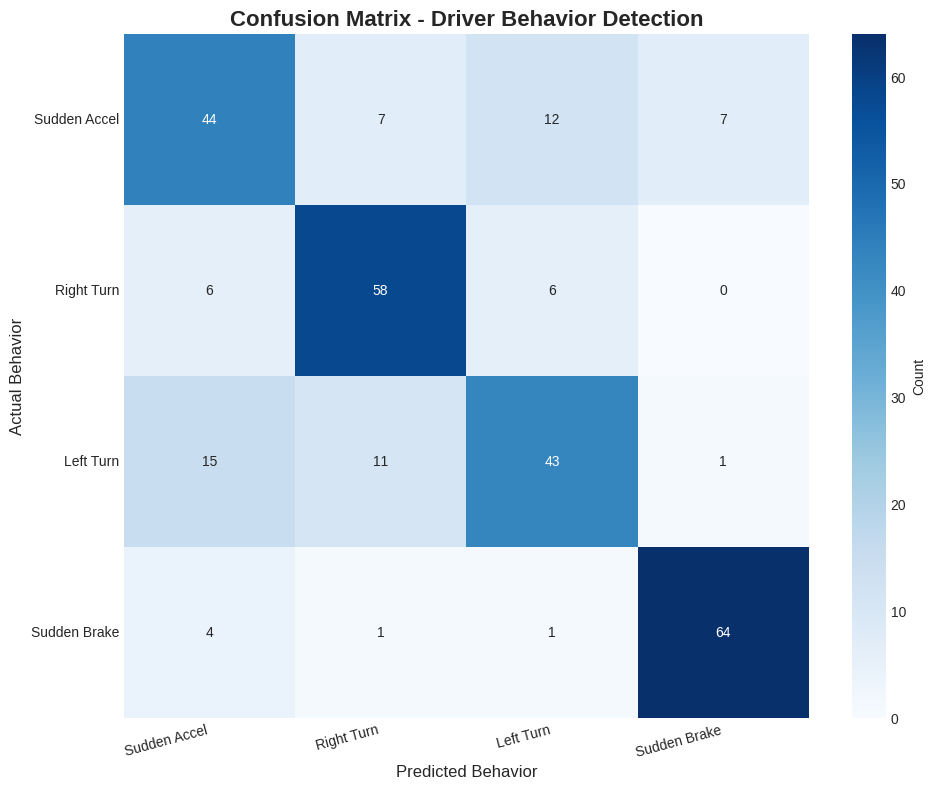

In [11]:
print("MODEL EVALUATION")

# Make predictions
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"\nTest Accuracy: {accuracy:.2%}")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

# Detailed classification report
print("\nClassification Report:")
target_names = ['Sudden Accel', 'Right Turn', 'Left Turn', 'Sudden Brake']
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Driver Behavior Detection', fontsize=16, fontweight='bold')
plt.ylabel('Actual Behavior', fontsize=12)
plt.xlabel('Predicted Behavior', fontsize=12)
plt.xticks(rotation=15, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## **Feature Importance Analysis**

FEATURE IMPORTANCE ANALYSIS

Top 10 Most Important Features:
        feature  importance
         gyro_z    0.146009
  accel_lateral    0.138772
        accel_x    0.126207
        accel_y    0.093720
     gyro_z_abs    0.093270
        accel_z    0.063271
 gyro_magnitude    0.062279
accel_magnitude    0.058849
 jerk_magnitude    0.058539
    accel_z_abs    0.055092


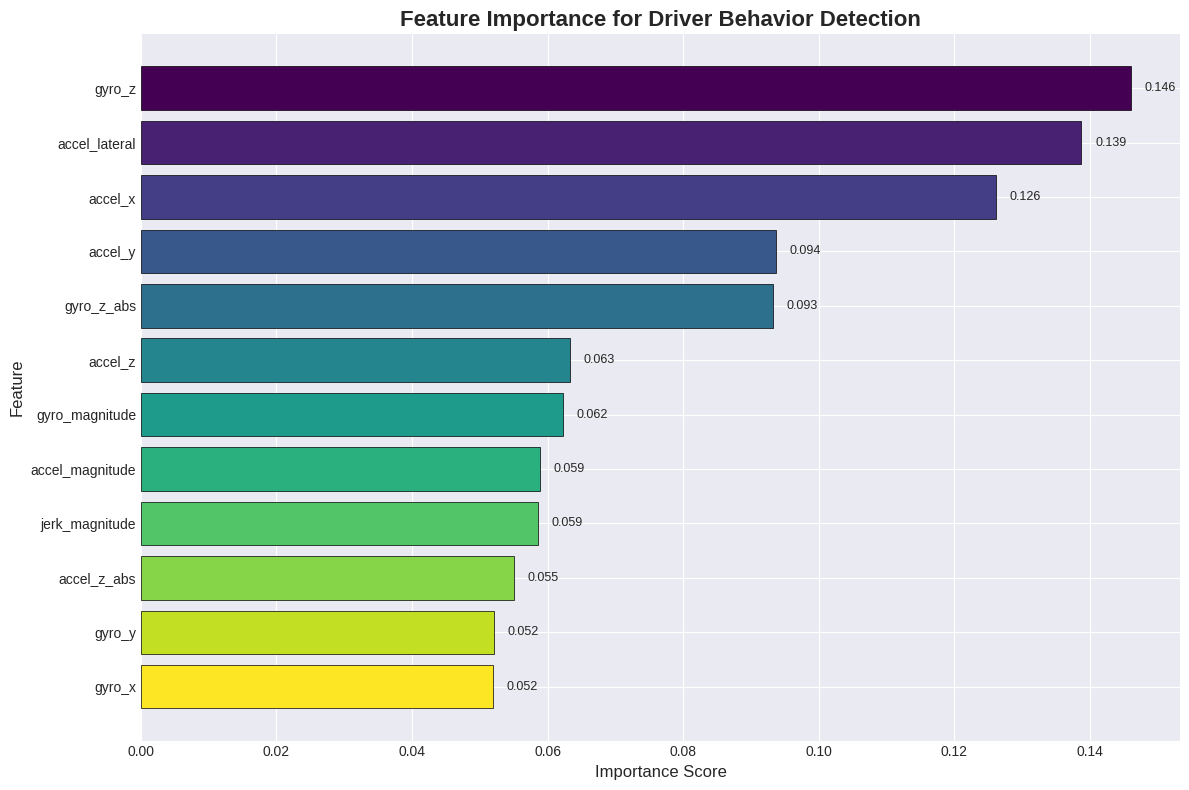


📡 Sensor Type Importance:
   Gyroscope features: 0.406 (40.6%)
   Accelerometer features: 0.594 (59.4%)


In [12]:
print("FEATURE IMPORTANCE ANALYSIS")

# Get feature importance
importance_df = pd.DataFrame({
    'feature': FINAL_FEATURES,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(importance_df)))
bars = plt.barh(importance_df['feature'][::-1], importance_df['importance'][::-1],
                color=colors[::-1], edgecolor='black', linewidth=0.5)
plt.title('Feature Importance for Driver Behavior Detection', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Add value labels
for bar, val in zip(bars, importance_df['importance'][::-1]):
    plt.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2,
             f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Group importance by sensor type
gyro_features = [f for f in FINAL_FEATURES if 'gyro' in f]
accel_features = [f for f in FINAL_FEATURES if 'accel' in f or 'jerk' in f]

gyro_importance = importance_df[importance_df['feature'].isin(gyro_features)]['importance'].sum()
accel_importance = importance_df[importance_df['feature'].isin(accel_features)]['importance'].sum()

print(f"\n📡 Sensor Type Importance:")
print(f"   Gyroscope features: {gyro_importance:.3f} ({gyro_importance*100:.1f}%)")
print(f"   Accelerometer features: {accel_importance:.3f} ({accel_importance*100:.1f}%)")